# Lesson 07

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "13.0.2" 2020-01-14; OpenJDK Runtime Environment (build 13.0.2+8); OpenJDK 64-Bit Server VM (build 13.0.2+8, mixed mode)
  Starting server from /home/dmitry/.virtualenvs/greekbrains/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmbxjt19p
  JVM stdout: /tmp/tmpmbxjt19p/h2o_dmitry_started_from_python.out
  JVM stderr: /tmp/tmpmbxjt19p/h2o_dmitry_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_dmitry_v1hrfy
H2O cluster total nodes:,1
H2O cluster free memory:,934 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


<a id=load></a>
### Load Data and Modules

In [2]:
url='https://d2xzmw6cctk25h.cloudfront.net/asset/1638603/attachment/8d4e96d11cdc1356e9382038772a407d.csv'

In [3]:
df = pd.read_csv(url, low_memory=False)

In [4]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

In [6]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [7]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [8]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [9]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [10]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [11]:
df = df.select_dtypes(exclude=['object'])

### Feature engineering

In [12]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,SocioCateg_CSP60,SocioCateg_CSP61,SocioCateg_CSP62,SocioCateg_CSP63,SocioCateg_CSP65,SocioCateg_CSP66,SocioCateg_CSP7,SocioCateg_CSP70,SocioCateg_CSP73,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,1,0,0,0,0,0,0,0,0,3249


<a id=encode></a>
### Preparing for modelling

In [13]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_train_ind, y_train_ind, test_size=0.5, random_state=1)

In [14]:
# Преобразование в H2O-Frame
h2o_train_c = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_c['ClaimInd'] = h2o_train_c['ClaimInd'].asfactor()
h2o_valid_c['ClaimInd'] = h2o_valid_c['ClaimInd'].asfactor()
h2o_test_c['ClaimInd'] = h2o_test_c['ClaimInd'].asfactor()

In [16]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm = H2OGeneralizedLinearEstimator(family = "binomial", link = "Logit", nfolds=5)
glm.train(y="ClaimInd", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [17]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 3.295E-5 )",55,55,3,py_1_sid_b708


In [18]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.5467663,0.042441864,0.5376711,0.60835165,0.49207544,0.56083316,0.53490025
1,auc,0.57700807,0.0103150485,0.5804152,0.58006346,0.57952476,0.58589774,0.5591392
2,aucpr,0.15986711,0.005761479,0.16077168,0.1547846,0.16281658,0.16743383,0.15352882
3,err,0.4532337,0.042441864,0.46232894,0.39164838,0.50792456,0.4391668,0.46509975
4,err_count,3231.327,295.891,3263.316,2801.375,3614.058,3144.802,3333.083
5,f0point5,0.1844739,0.0042800005,0.18164793,0.18445505,0.1845847,0.19138788,0.18029398
6,f1,0.24767566,0.0063606547,0.2459848,0.24148272,0.25301075,0.2556174,0.24228258
7,f2,0.37729236,0.019466687,0.38089016,0.3495536,0.40205282,0.38473356,0.36923167
8,lift_top_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,logloss,0.37925184,0.005898402,0.3735855,0.3728644,0.38186187,0.3812485,0.3866989


In [19]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.234515,-1.947353
1,LicAge,-0.000251,-0.039984
2,Gender,0.022667,0.010976
3,MariStat,-0.039995,-0.014301
4,DrivAge,-0.004324,-0.064716
5,HasKmLimit,-0.397822,-0.123612
6,BonusMalus,0.005523,0.083277
7,ClaimNbResp,0.044695,0.023436
8,ClaimNbNonResp,0.133648,0.079510
9,ClaimNbParking,0.174813,0.051533


In [20]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm.coef_norm()
for x in range(len(glm.cross_validation_models())):
    pmodels[x] = glm.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-1.94735,-1.94138,-1.94010,-1.95091,-1.94942,-1.95809
LicAge,-0.03998,-0.02854,-0.03703,-0.04498,-0.03766,-0.04038
Gender,0.01098,0.01445,0.00810,0.01691,0.00131,0.01481
MariStat,-0.01430,-0.01013,-0.02022,-0.01361,-0.01866,-0.01131
DrivAge,-0.06472,-0.06196,-0.11318,-0.06396,-0.12913,-0.08714
HasKmLimit,-0.12361,-0.13025,-0.10675,-0.12758,-0.11563,-0.13903
BonusMalus,0.08328,0.07736,0.07084,0.08658,0.08190,0.09386
ClaimNbResp,0.02344,0.02847,0.03095,0.01720,0.02458,0.01719
ClaimNbNonResp,0.07951,0.07764,0.08317,0.08104,0.07734,0.07835
ClaimNbParking,0.05153,0.05498,0.04475,0.05272,0.04856,0.05627


In [21]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm.predict(h2o_train_c).as_data_frame()
ac_valid_pred = glm.predict(h2o_valid_c).as_data_frame()
ac_test_pred = glm.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [23]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок
print(f'Accuracy score для обучающей выборки {accuracy_score(y_train_ind, ac_train_pred.predict)}')
print(f'Accuracy score для валидационной выборки {accuracy_score(y_valid_ind, ac_valid_pred.predict)}')
print(f'Accuracy score для тестовой выборки {accuracy_score(y_test_ind, ac_test_pred.predict)}')

Accuracy score для обучающей выборки 0.5159041286224693
Accuracy score для валидационной выборки 0.5176905518062723
Accuracy score для тестовой выборки 0.5141177054386661


In [24]:
print(f'F1 score для обучающей выборки {f1_score(y_train_ind, ac_train_pred.predict)}')
print(f'F1 score для валидационной выборки {f1_score(y_valid_ind, ac_valid_pred.predict)}')
print(f'F1 score для тестовой выборки {f1_score(y_test_ind, ac_test_pred.predict)}')

F1 score для обучающей выборки 0.19346037782646439
F1 score для валидационной выборки 0.19796179395139663
F1 score для тестовой выборки 0.18894180989852968


In [25]:
confusion_matrix(y_train_ind, ac_train_pred.predict)

array([[36906, 36067],
       [ 2955,  4680]])

In [26]:
confusion_matrix(y_valid_ind, ac_valid_pred.predict)

array([[18466, 17988],
       [ 1451,  2399]])

In [27]:
confusion_matrix(y_test_ind, ac_test_pred.predict)

array([[18440, 18079],
       [ 1504,  2281]])

Какие проблемы вы здесь видите? Как можно улучшить данный результат?

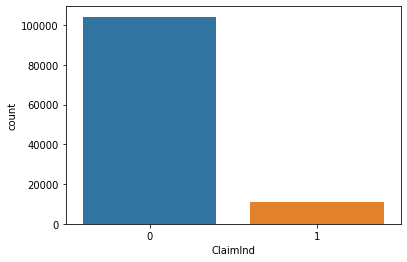

In [28]:
import seaborn as sns
sns.countplot(x=df.ClaimInd)

Классы целевой переменной не сбалансированы. Качество можно улучшить, если сбалансировать классы.

In [29]:
glm_balance = H2OGeneralizedLinearEstimator(family = "binomial", link = "Logit", nfolds=5, balance_classes=True)
glm_balance.train(y="ClaimInd", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
ac_train_pred = glm_balance.predict(h2o_train_c).as_data_frame()
ac_valid_pred = glm_balance.predict(h2o_valid_c).as_data_frame()
ac_test_pred = glm_balance.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
print(f'Accuracy score для обучающей выборки {accuracy_score(y_train_ind, ac_train_pred.predict)}')
print(f'Accuracy score для валидационной выборки {accuracy_score(y_valid_ind, ac_valid_pred.predict)}')
print(f'Accuracy score для тестовой выборки {accuracy_score(y_test_ind, ac_test_pred.predict)}')

Accuracy score для обучающей выборки 0.5203577808654228
Accuracy score для валидационной выборки 0.5222558554982136
Accuracy score для тестовой выборки 0.518459706232632


In [32]:
print(f'F1 score для обучающей выборки {f1_score(y_train_ind, ac_train_pred.predict)}')
print(f'F1 score для валидационной выборки {f1_score(y_valid_ind, ac_valid_pred.predict)}')
print(f'F1 score для тестовой выборки {f1_score(y_test_ind, ac_test_pred.predict)}')

F1 score для обучающей выборки 0.19423545839151365
F1 score для валидационной выборки 0.1981426727189439
F1 score для тестовой выборки 0.1903212348769295
